# Lab#3: Asking a statistical question

In [44]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import pandas as pd
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

## Problem 1

In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation). However, there are times when the thermal control system misbehaved and the temperature was not near 12 K, and in addition there are various glitches in the thermometry that give anomalously high and low readings (the reading does not match the real temperature). We definitely want to identify and throw out all the data when the thermal control system was not working (and the temperature was truly off from nominal). While it is possible to have an error in the thermometry such that the true temperature was fine, and we just had a wonky reading, in an abundance of caution we want to throw those values out too.

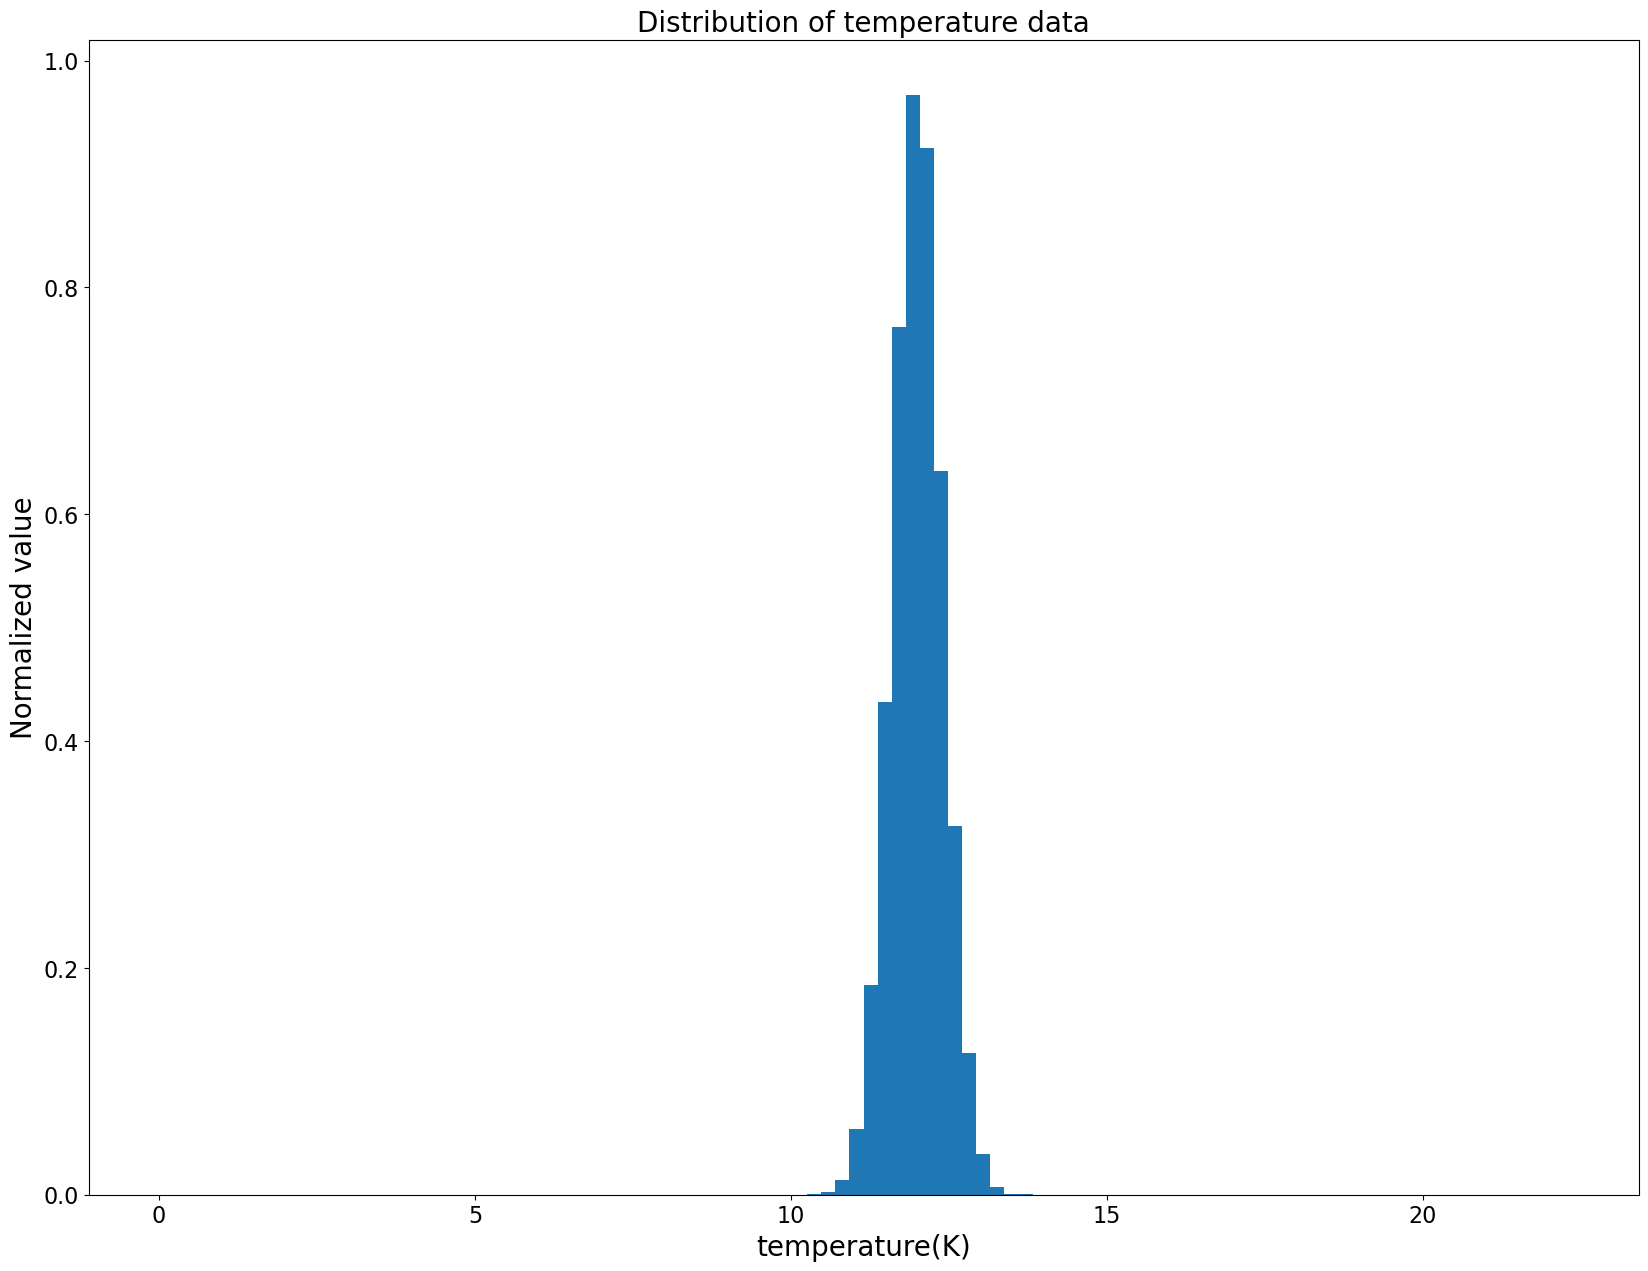

In [45]:
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 16)
#plt.yscale('log')
#x = np.linspace(4.95,5.05,1000)
#ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.title('Distribution of temperature data')
plt.xlabel('temperature(K)')
plt.ylabel('Normalized value')
ax. xaxis. label. set_size(20)
ax. yaxis. label. set_size(20)
ax.title.set_size(20)
plt.show()

To make this a bit concrete, we will simulate a little data. Start by simulating 100k 'good' data points assuming Gaussian fluctations, and because we are playing god adding the following 'bad' datapoints: {10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7}

### **A) So our goal is to identify bad data and throw it out.**

#### 1) Start by exploring the data you have created with appropriate plots

We can plot the semilog y plot of the ideal Gaussian distribuition(mean = 12, SD = 0.4)

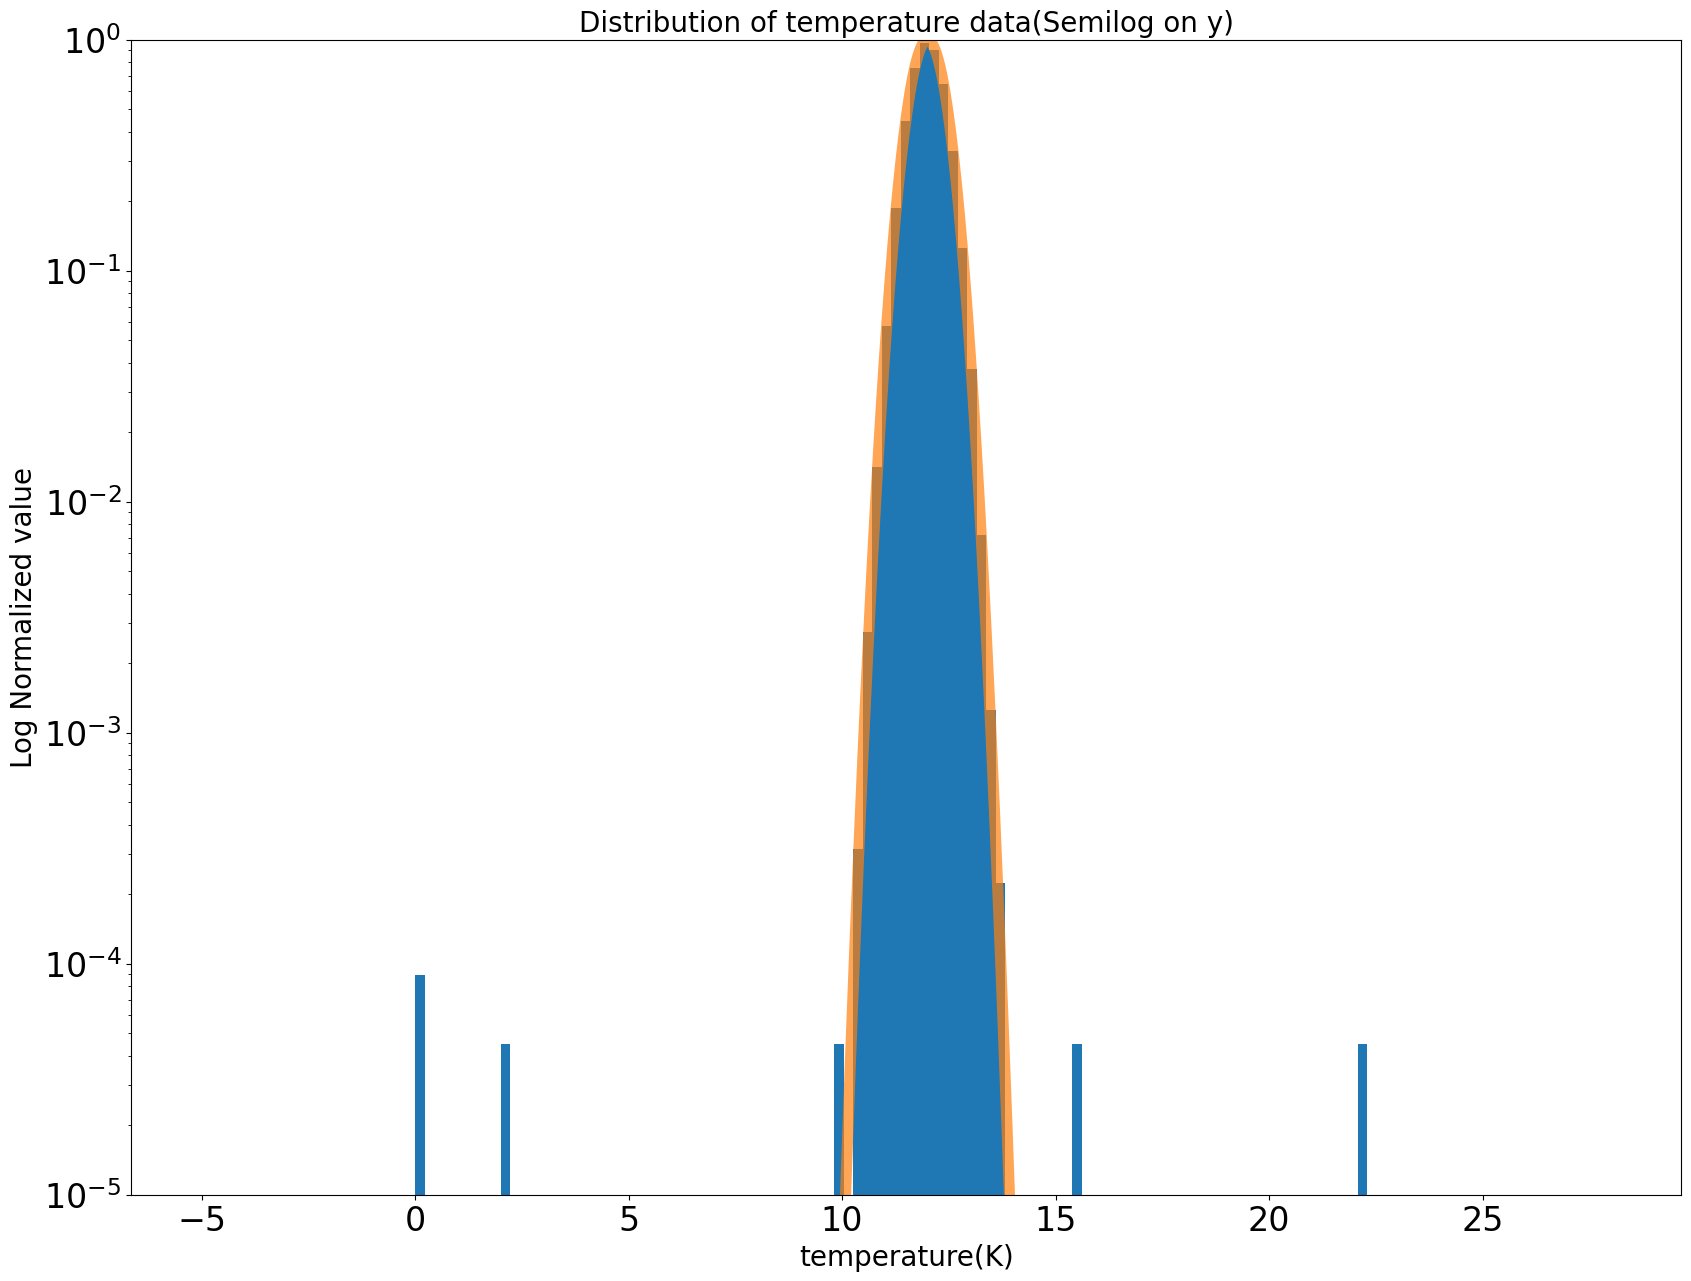

In [46]:
d = np.append(stats.norm.rvs(loc = 12., scale = 0.4, size = 100000), [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
fig, ax = plt.subplots(1, 1)
ax.hist(d,100, density=True)
plt.tick_params(labelsize = 24)

x = np.linspace(-5,28,1000)
plt.plot(x,stats.norm.pdf(x,loc = 12., scale = 0.4),linewidth = 8,alpha = 0.7)
plt.yscale('log')
plt.ylim(10**-5, 1)
plt.title('Distribution of temperature data(Semilog on y)')
plt.xlabel('temperature(K)')
plt.ylabel('Log Normalized value')
ax. xaxis. label. set_size(20)
ax. yaxis. label. set_size(20)
ax.title.set_size(20)
plt.show()

We can tell from the semilog plot that some data points are way off at the sides with respect to the distribution, which means they are very likely to be the noise. Next, we will distinguish if the those poitns can be tested as noise or a true data.

#### 2)State the statistical question in words. Be very clear, and describe why you have chosen this statistical question.

We can set up a threshold of probability, and all the values having a less probability of being considered from the real data than this threshold will be classified as noise. We can set our threshold to be $4\sigma$. Written in statisticcal question, what's the range of the temprature that the data points will have a proabbility smaller than $4\sigma$ to be observed, which make them more likely to be noise? How many data points like this are in our data?

#### 3)Restate your question in math. Be very clear.

At what x value, the integral of the ideal backgroujnd distribution(loc = 12, scale = 0.4) taken from that x value to inifinity will be equal to $4\sigma$?

#### 4)Apply your statistical test and construct a truth table.

In [47]:
prob4sigma = 1 - stats.norm.cdf(4, loc = 0, scale = 1) #equivalent probability of 4sigma
prob4sigma

3.167124183311998e-05

In [48]:
threshold = stats.norm.ppf(1 - prob4sigma, loc = 12, scale = 0.4) #upper bound of the range of values where data points have probability larger than prob4sigma
threshold

13.6

After obtaining the range of the temprature that the data points will have a proabbility smaller than $4\sigma$ to be observed, we are going to count how many data points are inside this range and how many of them are outside this range. We consider all the points outside the range to be false data(noise)

In [49]:
false_data_count = 0 #counts of false data points
fal = []
real_false = [10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7]
for data in d:
    if(data < 12 - (threshold - 12) or data > threshold):
        false_data_count += 1
        fal.append(data)
print('Number of tested false data point is ' + str(false_data_count))


Number of tested false data point is 16


We have classified 12 points to be noise. However, we know only 8 points are noisy data points. It means we must have classified several true data points as noisy data points. Now the question is: how many?

We can find the number of real false points that being tested as false as well

In [50]:
len(list(set(fal).intersection(real_false)))

6

So we successfully classified 6 false data points as noise. But we have 11 tested false points in total. It means 5 of the real data points was tested as noise by us. And it gives us enough information to complete our truth table.

In [51]:
data = {'True T':[99995, 5],
        'Bad T':[2,6]}
df = pd.DataFrame(data, index =['Our Test Good',
                                'Our Test Bad'])
df

,True T,Bad T
Our Test Good,99995,2
Our Test Bad,5,6


#### **B) How does the number of omissions, where you threw out good data, depend on the statistical threshold you chose and is it a predictable quantity?**

If we choose a more strict threshold(such as $6\sigma$), we will keep more good data from being thrown. Oppositely, a low threshold($2\sigma$) will consider more good data as bad data. Although it is impossible to predict the exact number of omissions, it is predicatable that more data will be thrown as we lower our threshold.

#### **C) Are there mistakes of commission (bad data getting in)? If yes, are they avoidable and how do they depend on your statistical threshold?**

There are mistakes of commission in our trial. It depends on the threshold in the exact opposite way as in part B: Stricter the threshold is, less bad data will be counted as good data. More loose the threshold is, more bad data will be included. In most cases, the mistakes will not be totally avoidable, since there are always some bad data points that fits the distirbution very well. But we can test multiple thresholds and decide a threshold that has the best tradeoff between the number of omissions and mistakes of commission.

## Problem 2

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS. Or said another way, if I histogram how far all the (stationary) stars appear to have moved I get something like:

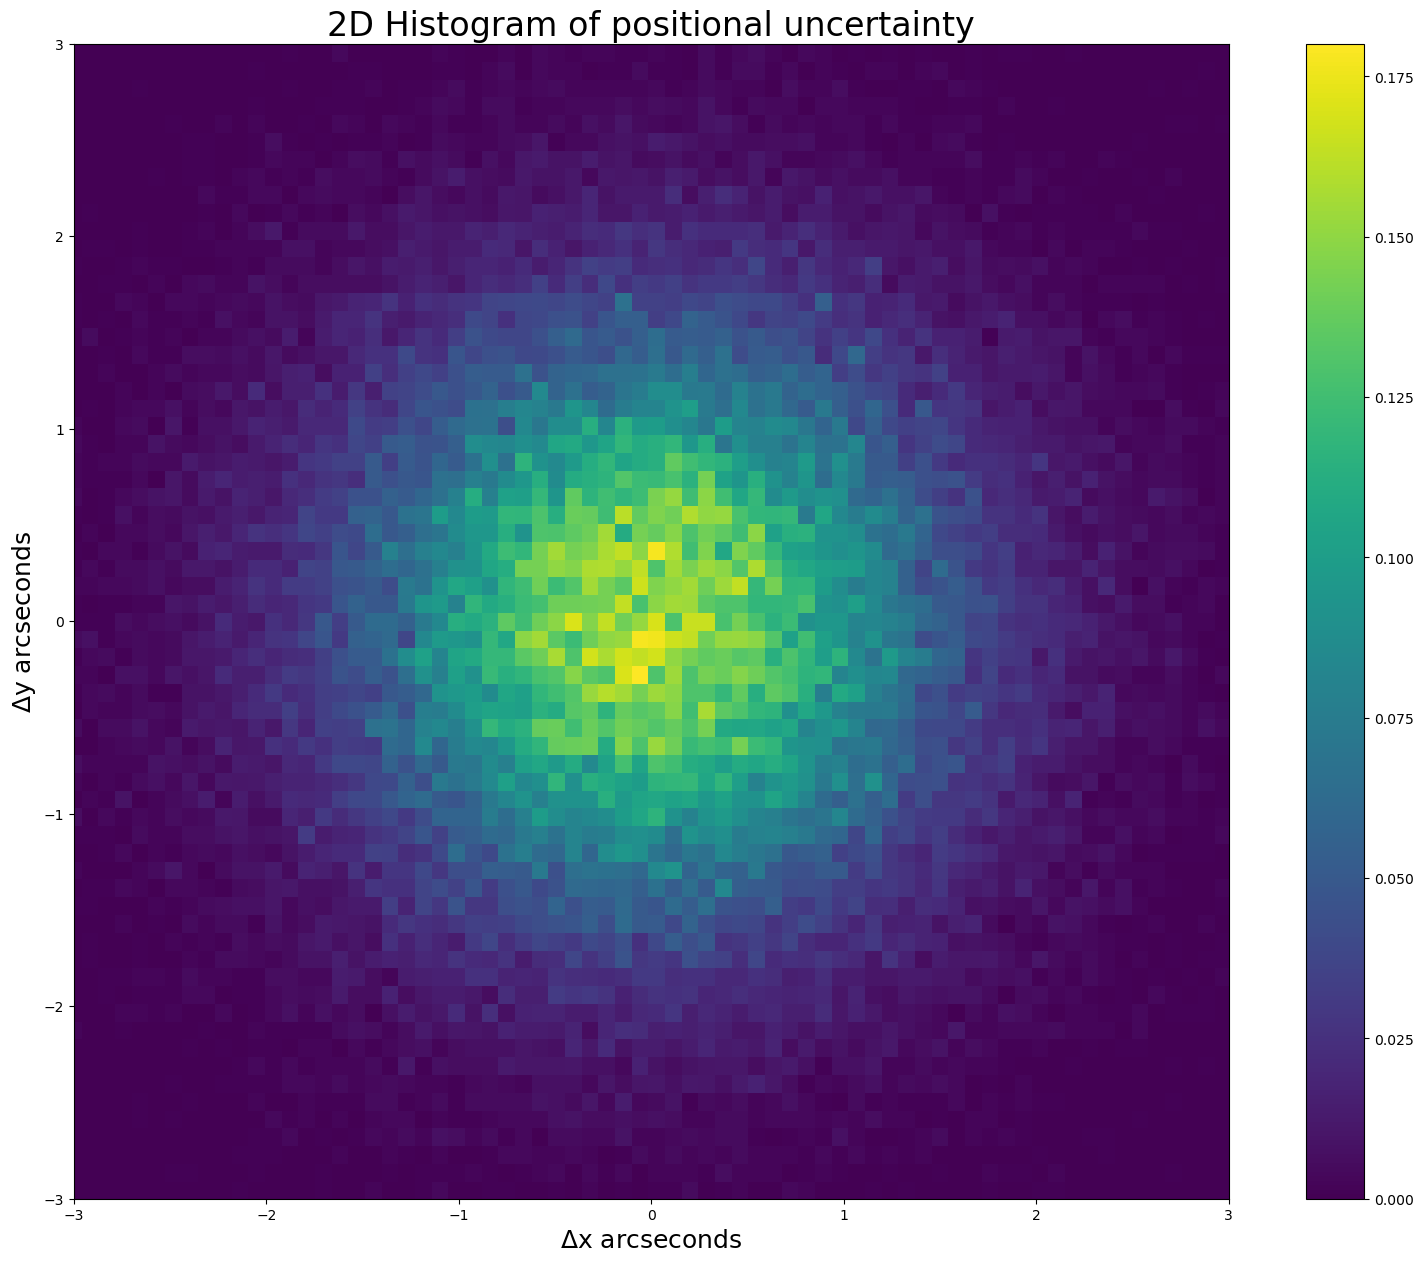

In [52]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)
plt.show()

If I have a potential asteroid, it will have some true movement between the images. We would like a '5 sigma' detection of movement. What is that distance in arcseconds?

#### **1)What is the question in words?**

As in part 2 of Problem 1, We set up a threshold of probability, and all the values having a less probability of being considered from the real data than this threshold will be classified as noise. In this case, it is stated specfically the threshold will be $5\sigma$. Written in statisticcal question, what's the range of the movement that the data points will have a proabbility smaller than $5\sigma$ to be observed, which make them more likely to be noise?

#### **2)What is the question in math?**

The amplitude of distance of the star $\Delta Z$, is clearly given by $\sqrt{(\Delta X)^2 + (\Delta Y)^2}$. And the probability distributions for $\Delta X$ and $\Delta Y$ are both given by a standard normal distribution. The distribution for $\Delta Z$ will be given by a Rayleigh distribution(We know it from Problem 2 of Homework 3). To be more specific,the pdf of Z is $$ z(t) = te^{\frac{-t^2}{2}}, t > 0$$

The significance is given by$$\int_{a}^{\infty}z(t)dt =\int_{a}^{\infty} te^{\frac{-t^2}{2}}dt$$ where $a$ decides the distance representing a $5\sigma$ detection of motion

The question is: What's the value of $a$ that will make the significance equal to $5\sigma$?

#### **3)What distance in arcseconds represents a 5 sigma detection of motion?**

In [53]:
prob5sigma = 1 - stats.norm.cdf(5, loc = 0, scale = 1) #numerical value of 5 sigma
a = stats.rayleigh.ppf(1 - prob5sigma) #corresponding a value
a

5.489079776034238

The value of $a$ turns out to be around **5.4891**, which would be our distance in arcsecond representing a $5\sigma$ detection of motion!

## Problem 3

As we discussed in class, one of the key backgrounds for gamma-ray telescopes are cosmic rays. Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume in a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

#### **1)What is the question in words?**

The number of cosmic rays in one minute observation follows a distribution of Poisson distribution (with a mean of 1 in this case). Now we observed for 15 days, 8 hours per day, and we observed 6800 cosmic rays, what's the probability that this observation is just a random fluke under the distribution of 15 days' cosmic rays detection?

#### **2)Translate the question to math, describing both the expected background pdf() and the integral you need to do**

The distribution of cosmic ray in 15 days observation will be sum(convolution) of a number of 15days * 8 hours/day * 60min/hours = 7200 poisson distributions, each with a mean of 1. One thing special about the convolution of poisson distributions is, the convolved distribution will also be a poisson distribution, with a mean of the sum of the means of all the poisson distributions being convolved. In this case, the final distribuiton of comic rays will be a poisson distribution with a mean of 7200.

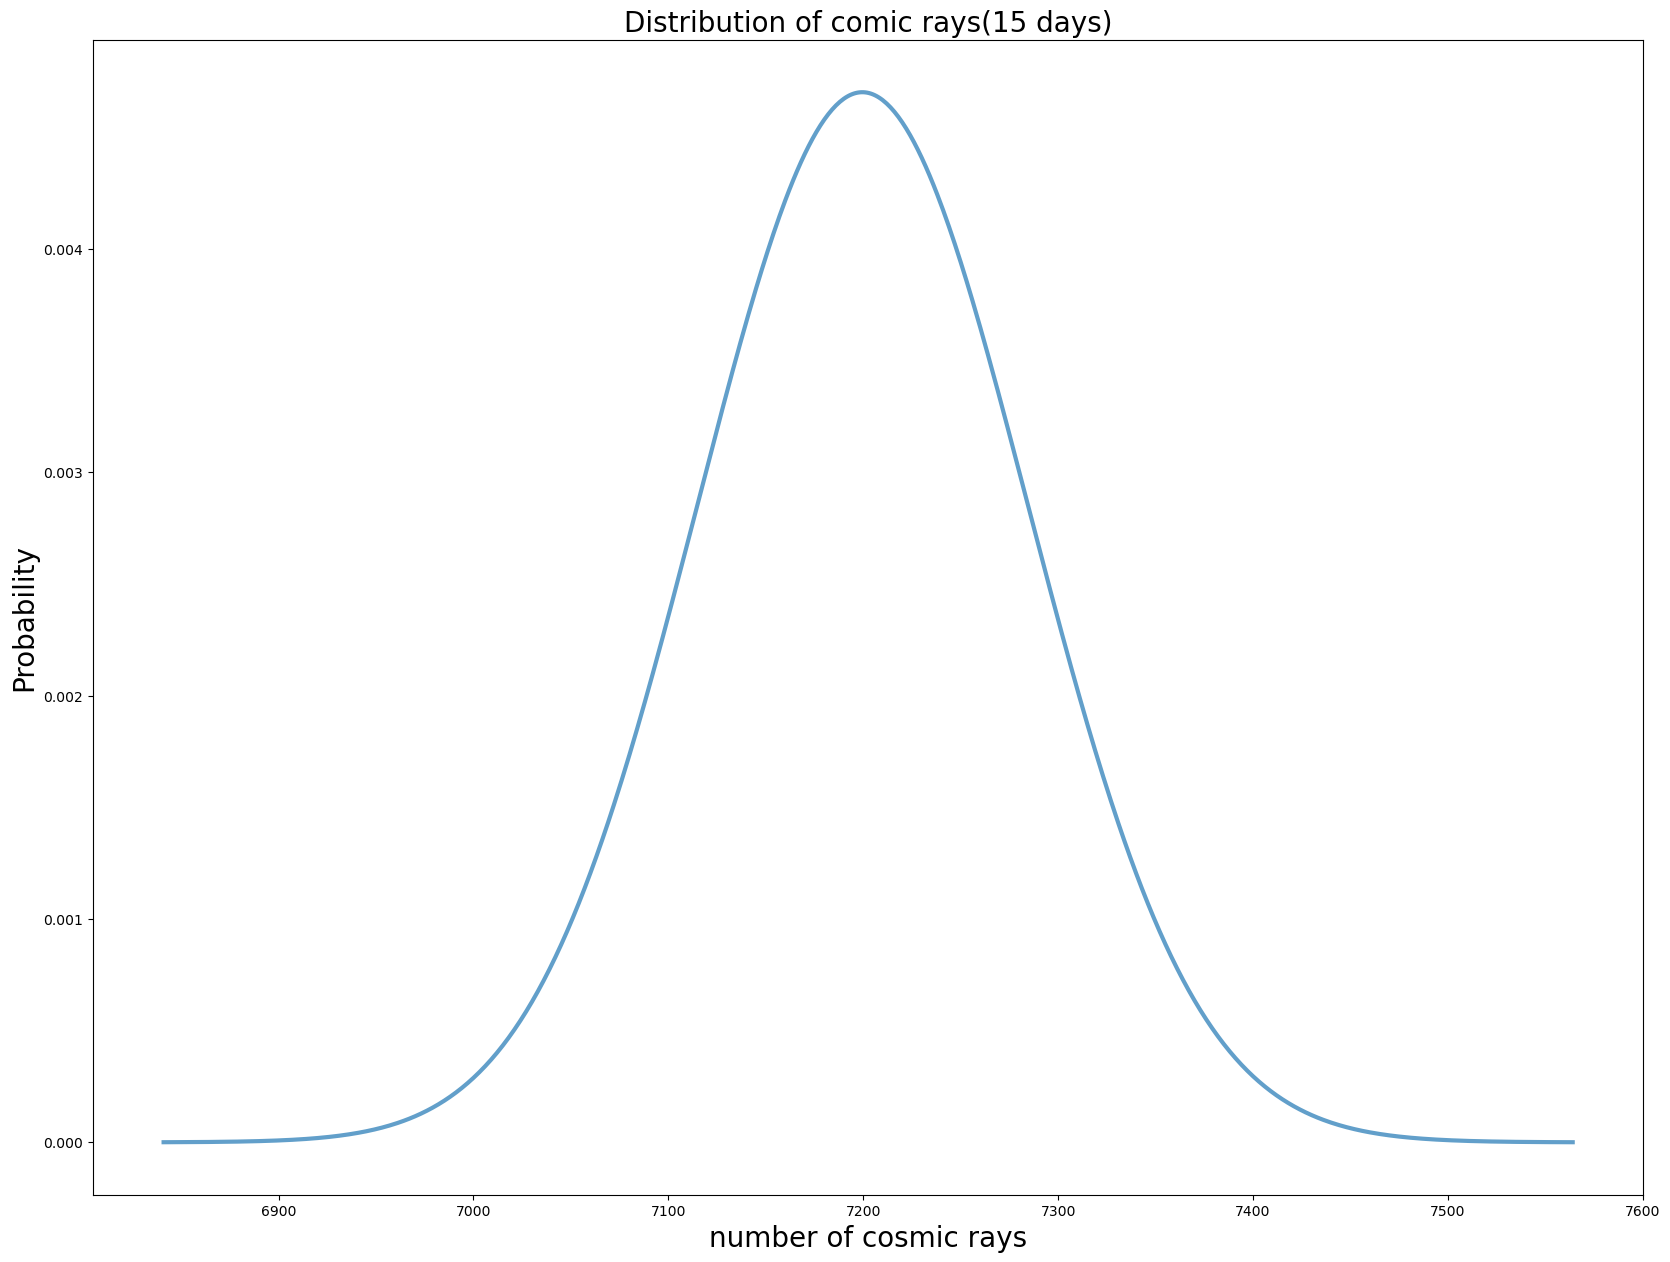

In [54]:
fig, ax = plt.subplots(1, 1)
dist = stats.poisson(7200)
mu = 7200
x = np.arange(stats.poisson.ppf(0.00001, mu), 
              stats.poisson.ppf(0.99999, mu))
dist_pmf = dist.pmf(x)
plt.plot(x,dist_pmf,linewidth = 3,alpha = 0.7)
plt.title('Distribution of comic rays(15 days)')
plt.xlabel('number of cosmic rays')
plt.ylabel('Probability')

ax. xaxis. label. set_size(20)
ax. yaxis. label. set_size(20)
ax.title.set_size(20)
plt.show()


The graph looks very similar to a Gaussian. 

Now we have the distribution for 15 days. Now asking our question in math: what's the probability of observing 6800 cosmic rays or less? What's the value (written in $\sigma$ ) of $\int_{0}^{6800}f(t) dt$, where $f(t)$ is the poisson distribution with mean 7200?

#### **3)Convert to sigma.**

In [55]:
prob = stats.poisson.cdf(6800, mu = 7200)
prob
probSigma = stats.norm.ppf(1-prob, loc = 0, scale = 1)
print('Equivalent sigma value is ' +str(probSigma))


Equivalent sigma value is 4.750747965778662


In [58]:
!jupyter nbconvert --to html Lab3_notebook.ipynb

[NbConvertApp] Converting notebook Lab3_notebook.ipynb to html
[NbConvertApp] Writing 955890 bytes to Lab3_notebook.html
